In [2]:
import tensorflow as tf
from six.moves import cPickle
import numpy as np

In [3]:
# Loading net skeleton with parameters name and shapes.
with open("util/net_skeleton.ckpt", "rb") as f:
    net_skeleton = cPickle.load(f)

In [4]:
num_layers    = [2, 2, 3, 3, 3, 1, 1, 1]
dilations     = [[1, 1],
                 [1, 1],
                 [1, 1, 1],
                 [1, 1, 1],
                 [2, 2, 2],
                 [12], 
                 [1], 
                 [1]]
n_classes = 21
ks = 3

In [5]:
def create_variable(name, shape):
    """Create a convolution filter variable of the given name and shape,
       and initialise it using Xavier initialisation 
       (http://jmlr.org/proceedings/papers/v9/glorot10a/glorot10a.pdf).
    """
    initialiser = tf.contrib.layers.xavier_initializer_conv2d(dtype=tf.float32)
    variable = tf.Variable(initialiser(shape=shape), name=name)
    return variable

In [6]:
def create_bias_variable(name, shape):
    """Create a bias variable of the given name and shape,
       and initialise it to zero.
    """
    initialiser = tf.constant_initializer(value=0.0, dtype=tf.float32)
    variable = tf.Variable(initialiser(shape=shape), name=name)
    return variable

In [7]:
def neural_net_image_input(image_shape):
        """
        Return a Tensor for a batch of image input
        : image_shape: Shape of the images
        : return: Tensor for image input.
        """
        # TODO: Implement Function
        return tf.placeholder(tf.float32,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="x")
def neural_net_label_input(image_shape):
        """
        Return a Tensor for a batch of image input
        : image_shape: Shape of the images
        : return: Tensor for image input.
        """
        # TODO: Implement Function
        return tf.placeholder(tf.int8,shape=(None,image_shape[0],image_shape[1],image_shape[2]),name="y")

def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32,name="keep_prob")

In [8]:
# def _create_variables(weights_path):
#         var = list()
#         index = 0
        
#         if weights_path is not None:
#             with open(weights_path, "rb") as f:
#                 weights = cPickle.load(f) # Load pre-trained weights.
#                 for name, shape in net_skeleton:
#                     var.append(tf.Variable(weights[name],
#                                            name=name))
#                 del weights
#         else:
#             # Initialise all weights randomly with the Xavier scheme,
#             # and 
#             # all biases to 0's.
#             for name, shape in net_skeleton:
#                 if "/w" in name: # Weight filter.
#                     w = create_variable(name, list(shape))
#                     var.append(w)
#                 else:
#                     b = create_bias_variable(name, list(shape))
#                     var.append(b)
#         return var
# variables = _create_variables(None)

In [9]:
# current = tf.convert_to_tensor(batch_features_array, dtype=tf.float32)
# v_idx = 0

In [10]:
# w = variables[v_idx * 2]
# b = variables[v_idx * 2 + 1]
# conv = tf.nn.conv2d(current, w, strides=[1, 1, 1, 1], padding='SAME')
# current = tf.nn.relu(tf.nn.bias_add(conv, b))
# current = tf.nn.max_pool(current, 
#                                          ksize=[1, ks, ks, 1],
#                                          strides=[1, 1, 1, 1],
#                                          padding='SAME')
# v_idx += 1

In [11]:
# w = variables[v_idx * 2]
# b = variables[v_idx * 2 + 1]
# conv = tf.nn.conv2d(current, w, strides=[1, 1, 1, 1], padding='SAME')
# current = tf.nn.relu(tf.nn.bias_add(conv, b))
# v_idx += 1

In [12]:
#tf.pack(current.get_shape()[1:3])

In [13]:
#labelBatch = tf.image.resize_nearest_neighbor(tf.convert_to_tensor(batch_labels_array_indexed, dtype=tf.int8), current.get_shape()[1:3])

In [14]:
class DeepLabLFOVModel(object):
    def __init__(self, weights_path=None):
        self.variables = self._create_variables(weights_path)
    
    def _create_variables(self, weights_path):
        var = list()
        index = 0
        
        if weights_path is not None:
            with open(weights_path, "rb") as f:
                weights = cPickle.load(f) # Load pre-trained weights.
                for name, shape in net_skeleton:
                    var.append(tf.Variable(weights[name],
                                           name=name))
                del weights
        else:
            # Initialise all weights randomly with the Xavier scheme,
            # and 
            # all biases to 0's.
            for name, shape in net_skeleton:
                if "/w" in name: # Weight filter.
                    w = create_variable(name, list(shape))
                    var.append(w)
                else:
                    b = create_bias_variable(name, list(shape))
                    var.append(b)
        return var
    
    def _create_network(self, input_batch, keep_prob):
        
        current = input_batch
        v_idx = 0
        for b_idx in range(len(dilations) - 1):
            for l_idx, dilation in enumerate(dilations[b_idx]):
                w = self.variables[v_idx * 2]
                b = self.variables[v_idx * 2 + 1]
                if dilation == 1:
                    conv = tf.nn.conv2d(current, w, strides=[1, 1, 1, 1], padding='SAME')
                else:
                    conv = tf.nn.atrous_conv2d(current, w, dilation, padding='SAME')
                current = tf.nn.relu(tf.nn.bias_add(conv, b))
                v_idx += 1
                
                if b_idx < 3:
                    current = tf.nn.max_pool(current, 
                                         ksize=[1, ks, ks, 1],
                                         strides=[1, 2, 2, 1],
                                         padding='SAME')
                elif b_idx == 3:
                    current = tf.nn.max_pool(current, 
                             ksize=[1, ks, ks, 1],
                             strides=[1, 1, 1, 1],
                             padding='SAME')
                elif b_idx == 4:
                    current = tf.nn.max_pool(current, 
                                         ksize=[1, ks, ks, 1],
                                         strides=[1, 1, 1, 1],
                                         padding='SAME')
                    current = tf.nn.avg_pool(current, 
                                         ksize=[1, ks, ks, 1],
                                         strides=[1, 1, 1, 1],
                                         padding='SAME')
                elif b_idx <= 6:
                    current = tf.nn.dropout(current, keep_prob=keep_prob)
        
        # Classification layer; no ReLU.
        w = self.variables[v_idx * 2]
        b = self.variables[v_idx * 2 + 1]
        conv = tf.nn.conv2d(current, w, strides=[1, 1, 1, 1], padding='SAME')
        current = tf.nn.bias_add(conv, b)

        return current
    
    
    def preds(self, input_batch,keep_prob_input):
        """Create the network and run inference on the input batch.
        
        Args:
          input_batch: batch of pre-processed images.
          
        Returns:
          Argmax over the predictions of the network of the same shape as the input.
        """
        
        raw_output = self._create_network(tf.cast(input_batch, tf.float32), keep_prob_input)
        print(raw_output.shape)
        raw_output = tf.image.resize_bilinear(raw_output, tf.shape(input_batch)[1:3,])
        print(raw_output.shape)
        raw_output = tf.argmax(raw_output, dimension=3)
        print(raw_output.shape)
        raw_output = tf.expand_dims(raw_output, dim=3) # Create 4D-tensor.
        print(raw_output.shape)
        return tf.cast(raw_output, tf.uint8)
    
    def loss(self, img_batch, label_batch,keep_prob_input):
        """Create the network, run inference on the input batch and compute loss.
        
        Args:
          input_batch: batch of pre-processed images.
          
        Returns:
          Pixel-wise softmax loss.
        """
        raw_output = self._create_network(tf.cast(img_batch, tf.float32), keep_prob)
        print(raw_output.shape)
        prediction = tf.reshape(raw_output, [-1, n_classes])
        
        labels= tf.image.resize_nearest_neighbor(tf.convert_to_tensor(label_batch, dtype=tf.int8), [4,4])
        gt = tf.reshape(labels, [-1, n_classes])
        print(label_batch.shape)
        # Pixel-wise softmax loss.
        loss = tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=gt)
        reduced_loss = tf.reduce_mean(loss)
        return reduced_loss










In [15]:
def prepare_label(label_batch):
        colormap = {(0,0,0):0, (128,0,0):1, (0,128,0):2, (128,128,0):3, (0,0,128):4, (128,0,128):5, (0,128,128):6, (128,128,128):7, (64,0,0):8, (192,0,0):9, (64,128,0):10, (192,128,0):11, (64,0,128):12, (192,0,128):13, 
            (64,128,128):14, (192,128,128):15, (0,64,0):16, (128,64,0):17, (0,192,0):18, (128,192,0):19, (0,64,128):20}                                            
        gndTruth = np.zeros((label_batch.shape[0],500,500,21), dtype=np.int)
        for i in range(label_batch.shape[0]):
            for j in range(500):
                for k in range(500):   
                    if(colormap.get(tuple(label_batch[i][j,k]))):
                        gndTruth[i,j,k,colormap.get(tuple(label_batch[i][j,k]))] = 1
                    else:
                        gndTruth[i,j,k,0] = 1
        return gndTruth
def encode_labels(label_batch):
        colormap = {(0,0,0):0, (128,0,0):1, (0,128,0):2, (128,128,0):3, (0,0,128):4, (128,0,128):5, (0,128,128):6, (128,128,128):7, (64,0,0):8, (192,0,0):9, (64,128,0):10, (192,128,0):11, (64,0,128):12, (192,0,128):13, 
            (64,128,128):14, (192,128,128):15, (0,64,0):16, (128,64,0):17, (0,192,0):18, (128,192,0):19, (0,64,128):20}                                            
        gndTruth = np.zeros((label_batch.shape[0],500,500,1), dtype=np.int)
        for i in range(label_batch.shape[0]):
            for j in range(500):
                for k in range(500):   
                    if(colormap.get(tuple(label_batch[i][j,k]))):
                        gndTruth[i,j,k]=colormap.get(tuple(label_batch[i][j,k]))
                    else:
                        gndTruth[i,j,k] = 0
        return gndTruth

In [16]:
def load_preprocess_training_batch(batch_id):
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    filename = 'preprocessed/pre_processed_batch_' + str(batch_id) + '.p'
    features, labels = cPickle.load(open(filename, mode='rb'))
    # Return the training data in batches of size <batch_size> or less
    return features, labels

In [137]:
epochs = 2
batch_size = 256
keep_probability = 0.75

tf.reset_default_graph()

# Inputs
x = neural_net_image_input((500, 500, 3))
y = neural_net_label_input((500, 500, 21))
keep_prob = neural_net_keep_prob_input()

net = DeepLabLFOVModel()
cost = net.loss(x, y,keep_prob)
cost_summary=tf.summary.scalar("loss",cost)
optimizer = tf.train.AdamOptimizer().minimize(cost)
save_model_path = "./capstone"
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    file_writer = tf.summary.FileWriter('/Users/systems/Downloads/udacity/machine-learning-master/projects/capstone/logs/', sess.graph)
    # Training cycle
    for epoch in range(epochs):
        for batch_i  in range(0, 2):
            batch_features, batch_labels = load_preprocess_training_batch(batch_i)
            batch_features_array = np.zeros((len(batch_features),500,500,3))
            batch_labels_array = np.zeros((len(batch_features),500,500,3))
            i=0
            for b in batch_features:
                batch_features_array[i] = b
                i=i+1
            batch_features_array = batch_features_array.astype(np.float32)
            i=0
            for b in batch_labels:
                batch_labels_array[i] = b
                i=i+1
            batch_labels_array_indexed = prepare_label(batch_labels_array)
            _,cost_batch=sess.run([optimizer,cost_summary],feed_dict={x:batch_features_array,y:batch_labels_array_indexed,keep_prob:keep_probability})
            file_writer.add_summary(cost_batch, epoch)
    saver = tf.train.Saver();  
    saver.save(sess, save_model_path)

(?, ?, ?, 21)
(?, 500, 500, 21)


In [17]:
from PIL import Image
import numpy as np

# Colour map.
label_colours = [(0,0,0)
                # 0=background
                ,(128,0,0),(0,128,0),(128,128,0),(0,0,128),(128,0,128)
                # 1=aeroplane, 2=bicycle, 3=bird, 4=boat, 5=bottle
                ,(0,128,128),(128,128,128),(64,0,0),(192,0,0),(64,128,0)
                # 6=bus, 7=car, 8=cat, 9=chair, 10=cow
                ,(192,128,0),(64,0,128),(192,0,128),(64,128,128),(192,128,128)
                # 11=diningtable, 12=dog, 13=horse, 14=motorbike, 15=person
                ,(0,64,0),(128,64,0),(0,192,0),(128,192,0),(0,64,128)]
                # 16=potted plant, 17=sheep, 18=sofa, 19=train, 20=tv/monitor
    
def decode_labels(mask):
    """Decode batch of segmentation masks.
    
    Args:
      label_batch: result of inference after taking argmax.
    
    Returns:
      An batch of RGB images of the same size
    """
    img = Image.new('RGB', (len(mask[0]), len(mask)))
    pixels = img.load()
    for j_, j in enumerate(mask):
        for k_, k in enumerate(j):
            if k < 21:
                pixels[k_,j_] = label_colours[k]
    return np.array(img)

In [18]:
net = DeepLabLFOVModel()
batch_i=0;
save_model_path = "./capstone"
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loader = tf.train.import_meta_graph(save_model_path + '.meta')
    loader.restore(sess, save_model_path)
    loaded_graph=tf.get_default_graph()
    loaded_x = loaded_graph.get_tensor_by_name('x:0')
    loaded_y = loaded_graph.get_tensor_by_name('y:0')
    loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    pred = net.preds(loaded_x,loaded_keep_prob)
    print(pred.shape)

    label_img=tf.placeholder(tf.int8,shape=(None,500,500,1))
    mIoU, update_op = tf.contrib.metrics.streaming_mean_iou(pred, label_img, num_classes=21) 
    sess.run(tf.local_variables_initializer())
    batch_vfeatures, batch_vlabels = load_preprocess_training_batch(batch_i)
    
    batch_vfeatures_array = np.zeros((len(batch_vfeatures),500,500,3))
    batch_vlabels_array = np.zeros((len(batch_vfeatures),500,500,3))
    i=0
    for b in batch_vfeatures:
        batch_vfeatures_array[i] = b
        i=i+1
    batch_vfeatures_array = batch_vfeatures_array.astype(np.float32)
    i=0
    for b in batch_vlabels:
        batch_vlabels_array[i] = b
        i=i+1
    batch_vlabels_array_indexed = encode_labels(batch_vlabels_array)
          
            
    preds,_,mIoUValue = sess.run([pred,update_op,mIoU],feed_dict={loaded_x:batch_vfeatures_array,label_img:batch_vlabels_array_indexed,loaded_keep_prob:1.0})
#    mIoU, update_op = tf.contrib.metrics.streaming_mean_iou(preds, batch_vlabels_array, num_classes=21) 
    print('Mean IoU: {:.3f}'.format(mIoUValue))

(?, ?, ?, 21)
(?, ?, ?, 21)
(?, ?, ?)
(?, ?, ?, 1)
(?, ?, ?, 1)
Mean IoU: 0.000


In [25]:
from matplotlib import pyplot as plt
fig, axes = plt.subplots(2, 3, figsize = (16, 12))
i=0
IMG_MEAN=np.array((104.00698793,116.66876762,122.67891434), dtype=np.float32)
axes.flat[i * 3].set_title('data')
axes.flat[i * 3].imshow((batch_vfeatures_array[i])[:, :, ::-1].astype(np.uint8))

axes.flat[i * 3 + 1].set_title('mask')
axes.flat[i * 3 + 1].imshow(batch_vlabels_array[i, :, :, 0])

axes.flat[i * 3 + 2].set_title('pred')
axes.flat[i * 3 + 2].imshow(decode_labels(preds[i, :, :, 0]))
plt.savefig("./capstone" + str(0) + ".png")
# plt.close(fig)
# saver = tf.train.Saver(); 
# saver.save(sess, "./capstone")

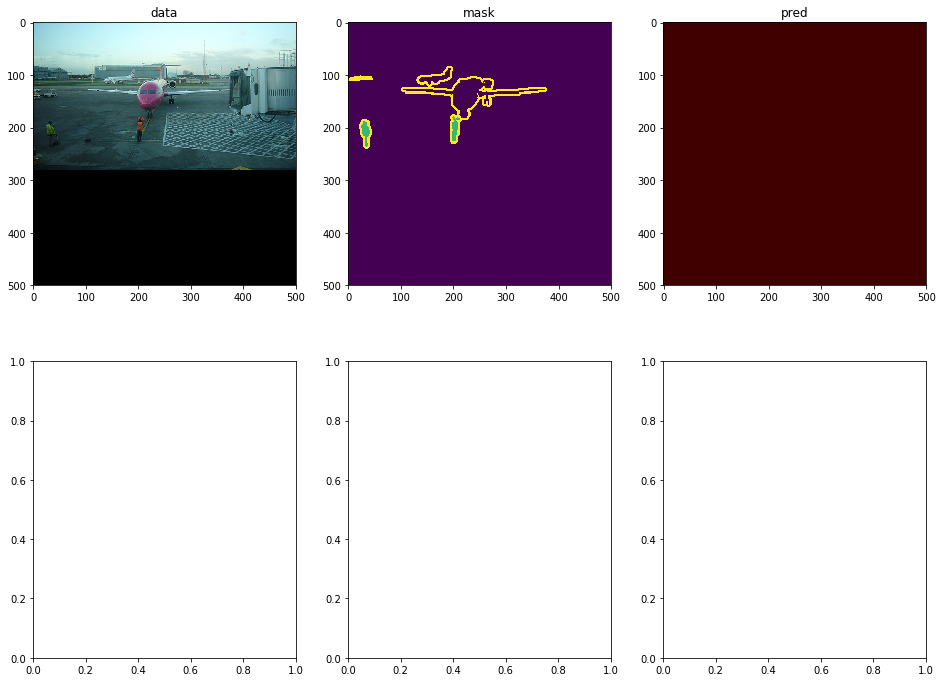

In [26]:
plt.show()